# Mini Projet

**XIA Xuanzhe**

**Sujet**: Flowers

L'ensemble de données sur la reconnaissance des fleurs contient des images de fleurs classées en deux catégories : marguerite et pissenlit.

## 0. Importation de données

In [1]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog, local_binary_pattern
from skimage import data, exposure
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, adjusted_rand_score
from scipy.stats import mode



# Define dataset directories
daisy_dir = "./Dataset/daisy"
dandelion_dir = "./Dataset/dandelion"

# Define parameters
img_height = 256
img_width = 256


In [2]:
def load_images_from_folder(folder, label, img_height, img_width):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=(img_height, img_width))
        img = img_to_array(img)  # Convertir en tableau numpy
        images.append(img)
        labels.append(label)  # Utiliser l'étiquette (0 pour daisy, 1 pour dandelion)
    return images, labels

# Charger les données
daisy_images, daisy_labels = load_images_from_folder(daisy_dir, 0, img_height, img_width)
dandelion_images, dandelion_labels = load_images_from_folder(dandelion_dir, 1, img_height, img_width)

# Combiner des images et des étiquettes de daisy et de dandelion
X = np.array(daisy_images + dandelion_images)
y = np.array(daisy_labels + dandelion_labels)

Vérifier si les données de l'image ont été importées et chargées avec succès dans la mémoire.

In [3]:
# Vérifier la forme des données
print(f"Shape of X (images): {X.shape}")
print(f"Shape of y (labels): {y.shape}")

Shape of X (images): (1821, 256, 256, 3)
Shape of y (labels): (1821,)


L'ensemble de données comprend 1821 images.

La taille de chaque image est de 256x256 pixels.

3 signifie que chaque image est une image couleur avec 3 canaux (correspondant à RVB : rouge, vert et bleu).

Caractère raisonnable de la répartition des catégories

In [4]:
unique, counts = np.unique(y, return_counts=True)
print(f"Label distribution: {dict(zip(unique, counts))}")

Label distribution: {np.int64(0): np.int64(769), np.int64(1): np.int64(1052)}


## 1. Prétraitement

### 1.1. Débruitage
Nous utilisons le flou gaussien pour éliminer le bruit.

In [5]:
def denoise_image(image):
    return cv2.GaussianBlur(cv2.resize(image, (0, 0), fx=0.25, fy=0.25), (5, 5), 0)

In [6]:
X_denoised = np.array([denoise_image(img) for img in X])

### 1.2. Augmentation et Normalisation

Nous procédons maintenant à l'augmentation des données et aux opérations de normalisation.

Nous Utilisons ImageDataGenerator pour l'amélioration de l'image.

In [7]:
def adjust_brightness_contrast(image, brightness=0, contrast=0):
    beta = brightness
    alpha = (contrast + 100) / 100.0
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

def color_jitter(image, hue_shift=0.1, saturation_scale=0.8):
    hsv_img = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_img)
    h = (h.astype(np.int16) + int(hue_shift * 255)) % 255
    h = h.astype(np.uint8)
    s = np.clip(s.astype(np.float32) * saturation_scale, 0, 255).astype(np.uint8)
    hsv_img = cv2.merge([h, s, v])
    rgb_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
    return rgb_img / 255.0

datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_image_pipeline(image, datagen, brightness=20, contrast=20, hue_shift=0.1, saturation_scale=0.8):

    image = adjust_brightness_contrast(image, brightness=brightness, contrast=contrast)

    image = color_jitter(image, hue_shift=hue_shift, saturation_scale=saturation_scale)
    image = np.expand_dims(image, axis=0)
    augmented_images = datagen.flow(image, batch_size=1)
    return next(augmented_images)[0] 

X_augmented = []
y_augmented = []

for img, label in zip(X_denoised, y):
    for _ in range(5):
        aug_img = augment_image_pipeline(img / 255.0, datagen, brightness=30, contrast=30, hue_shift=0.2, saturation_scale=0.9)
        X_augmented.append(aug_img)
        y_augmented.append(label)

X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

print(f"Augmentation du volume de données: {X_augmented.shape[0]} images")


Augmentation du volume de données: 9105 images


In [8]:
# X_augmented = []
# y_augmented = []
# for img, label in zip(X_denoised, y):
#     img = np.expand_dims(img, axis=0)  # Ajouter une dimension de lot
#     augmented_images = datagen.flow(img, batch_size=1)
#     for _ in range(5):  # Générer 5 images augmentées par image d'entrée
#         aug_img = next(augmented_images)[0]  # Récupérer l'image augmentée
#         X_augmented.append(aug_img)
#         y_augmented.append(label)

# X_augmented = np.array(X_augmented)
# y_augmented = np.array(y_augmented)

## 2. Extraction d'Attributs

Méthode d'extraction des caractéristiques de base :

1. HOG : pour capturer les formes et les contours.
2. LBP : pour capturer les caractéristiques de texture.
3. Histogramme des couleurs : pour capturer la distribution des couleurs.
Combinaison de trois méthodes 

### 2.1. Extraire les caractéristiques LBP

In [9]:
def extract_lbp_features(images, radius=1, n_points=8):
    features = []
    for img in images:
        gray = rgb2gray(img) / 255.0 # Convertir en niveaux de gris
        lbp = local_binary_pattern(gray, P=n_points, R=radius, method="uniform")
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)  # Normalize the histogram
        features.append(hist)
    return np.array(features)

### 2.2. Extraire les caractéristiques HOG

In [10]:
def extract_hog_features(images):
    features = []
    for img in images:
        gray = rgb2gray(img) / 255.0 # Convert to grayscale
        hog_features = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
        features.append(hog_features)
    return np.array(features)

### 2.3. Extraire les caractéristiques de l'histogramme des couleurs

In [11]:
def extract_color_histograms(images, bins=(8, 8, 8)):
    features = []
    for img in images:
        hist = cv2.calcHist([img], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        features.append(hist)
    return np.array(features)

In [12]:
def extract_sift_features(images):
    sift = cv2.SIFT_create()
    features = []
    for img in images:
        gray = (rgb2gray(img) * 255).astype(np.uint8)
        kp, des = sift.detectAndCompute(gray, None)
        if des is not None:
            features.append(des.mean(axis=0))
        else:
            features.append(np.zeros(128))
    return np.array(features)

In [13]:
def extract_eoh_features(images, bins=36):
    features = []
    for img in images:
        gray = rgb2gray(img)
        edges = cv2.Canny((gray * 255).astype(np.uint8), 100, 200)
        angles = np.arctan2(np.gradient(edges)[0], np.gradient(edges)[1])
        hist, _ = np.histogram(angles, bins=bins, range=(-np.pi, np.pi))
        features.append(hist / hist.sum()) 
    return np.array(features)


In [14]:
from skimage.feature import graycomatrix, graycoprops

def extract_glcm_features(images, distances=[5], angles=[0], props=['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']):
    features = []
    for img in images:
        gray = (rgb2gray(img) * 255).astype(np.uint8)
        glcm = graycomatrix(gray, distances=distances, angles=angles, symmetric=True, normed=True)
        feats = []
        for prop in props:
            feats.extend(graycoprops(glcm, prop).flatten())
        features.append(feats)
    return np.array(features)



In [15]:
def extract_gabor_features(images, kernels):
    features = []
    for img in images:
        gray = rgb2gray(img)
        feats = []
        for kernel in kernels:
            filtered = cv2.filter2D(gray, cv2.CV_32F, kernel)
            feats.append(np.mean(filtered))
            feats.append(np.std(filtered))
        features.append(np.array(feats))
    return np.array(features)

gabor_kernels = []
for theta in np.arange(0, np.pi, np.pi / 4):
    kernel = cv2.getGaborKernel((9, 9), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
    gabor_kernels.append(kernel)


Maintenant, on peut utiliser trois méthodes pour extraire les caractéristiques des images

In [16]:
hog_features = extract_hog_features(X_augmented)
lbp_features = extract_lbp_features(X_augmented)
color_hist_features = extract_color_histograms(X_augmented)

# sift_features = extract_sift_features(X_augmented)
# eoh_features = extract_eoh_features(X_augmented)
# glcm_features = extract_glcm_features(X_augmented)
# gabor_features = extract_gabor_features(X_augmented, gabor_kernels)


X_combined_features = np.hstack([hog_features, lbp_features,color_hist_features]) # ,sift_features,eoh_features,glcm_features,gabor_features

c:\Users\30586\Desktop\Miniprojet\.venv\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Normaliser les caractéristiques

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined_features)

Après le découpage des caractéristiques, PCA est appliquée pour la réduction de la dimensionnalité

Nombre de caractéristiques originales: 2286
Nombre de caractéristiques après réduction de la dimensionnalité: 609
Proportion cumulative de la variance expliquée: 0.9501


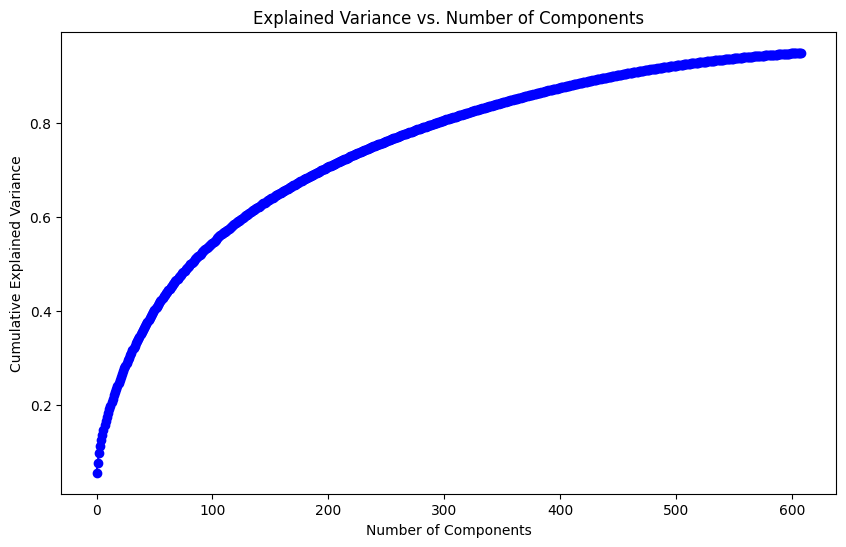

In [18]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_scaled)

print(f"Nombre de caractéristiques originales: {X_combined_features.shape[1]}")
print(f"Nombre de caractéristiques après réduction de la dimensionnalité: {X_reduced.shape[1]}")
print(f"Proportion cumulative de la variance expliquée: {np.sum(pca.explained_variance_ratio_):.4f}")

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()

L'effet de la réduction de la dimensionnalité est très important :

La redondance des caractéristiques est réduite :
PCA supprime les caractéristiques redondantes qui ont une faible variance et contribuent peu au modèle.

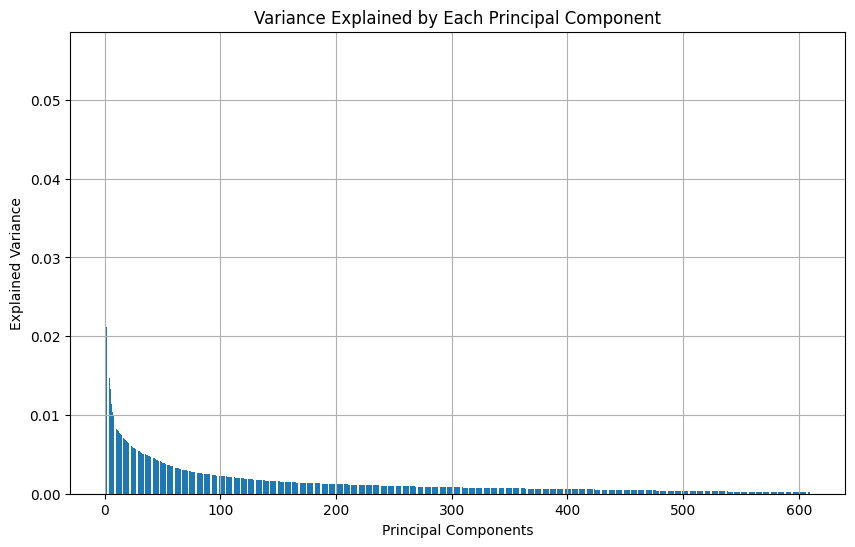

In [19]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance')
plt.title('Variance Explained by Each Principal Component')
plt.grid(True)
plt.show()

Les premières 200 composantes principales sont très importantes et capturent la plupart des informations sur les données.
Le nombre de composantes principales peut être considérablement réduit, tout en conservant la plupart des caractéristiques des données.

In [20]:
pca = PCA(n_components=200)
X_reduced = pca.fit_transform(X_scaled)

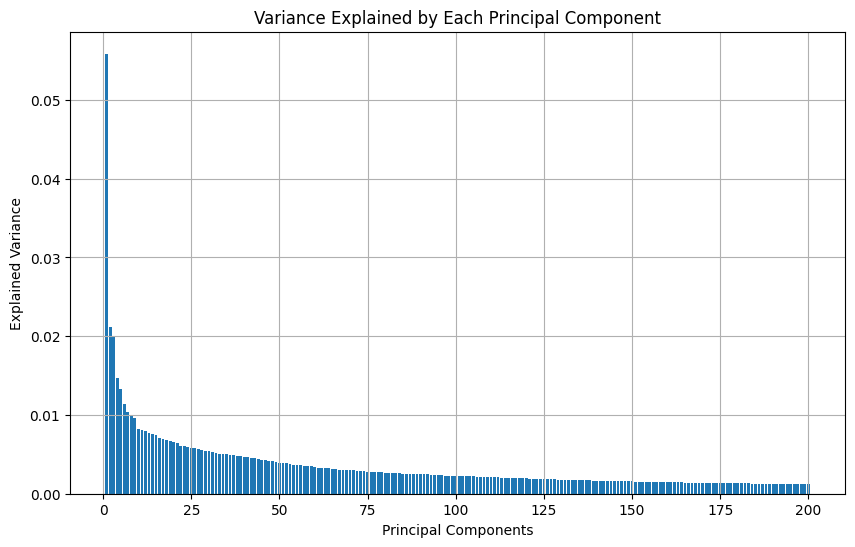

In [21]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance')
plt.title('Variance Explained by Each Principal Component')
plt.grid(True)
plt.show()

## 3. Classifier

Algorithmes d'apprentissage non supervisé

### 3.1. K-means

In [22]:
X_reduced.shape

(9105, 200)

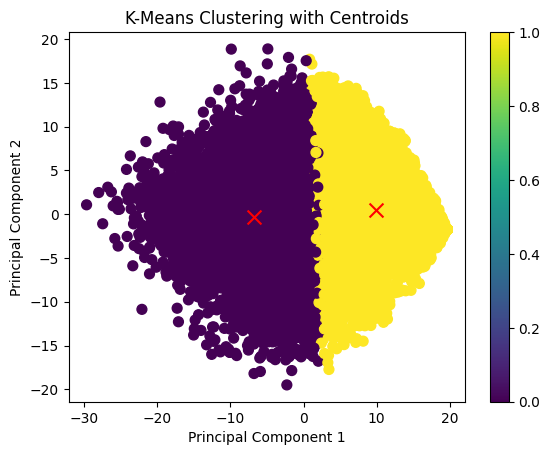

In [23]:
kmeans = KMeans(n_clusters=2, random_state=42)  # Ici, on suppose 2 clusters (daisy et dandelion)
kmeans_labels = kmeans.fit_predict(X_reduced)

# Visualisation des clusters
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans_labels, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=100)
plt.title('K-Means Clustering with Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

**Validation Index for Clustering**

In [24]:
accuracy = accuracy_score(y_augmented, kmeans_labels)
print(f"Accuracy of K-Means clustering: {accuracy:.4f}")

Accuracy of K-Means clustering: 0.6238


### SVM

In [25]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_augmented, test_size=0.2, random_state=42)

# Train the SVM classifier
svm = SVC(kernel='poly', random_state=42)
svm.fit(X_train, y_train)

# Make predictions
y_pred = svm.predict(X_test)

Accuracy: 0.6985
Adjusted Rand Index (ARI): 0.1538


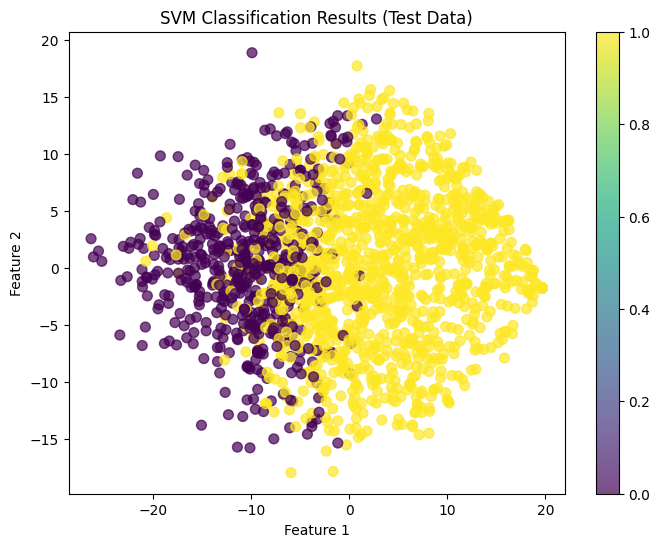

In [26]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
ari_score = adjusted_rand_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis', s=50, alpha=0.7)
plt.title('SVM Classification Results (Test Data)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar()
plt.show()